In [3]:
import torch
import torchvision
import cv2
import numpy as np
import matplotlib.pyplot as plt

/home/vscode/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
hf_path = 'https://huggingface.co/jspark2000/yolov5-vehicle/resolve/main/best.pt'
yolov5_model = torch.hub.load('ultralytics/yolov5', 'custom', path=hf_path, force_reload=True)

mask_rcnn_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
mask_rcnn_model.eval()


def pad_to_square(image):
    width, height = image.size
    max_side = max(width, height)
    padding = (
        (max_side - width) // 2,
        (max_side - height) // 2,
        (max_side - width + 1) // 2,
        (max_side - height + 1) // 2,
    )
    return torchvision.transforms.functional.pad(image, padding, fill=0, padding_mode='constant')


def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image file not found at {image_path}")
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image_rgb


def detect_objects(image):
    results = yolov5_model(image)
    return results.xyxy[0].cpu().numpy()


def segment_objects(image, boxes, target_size=(256, 256)):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Lambda(pad_to_square),
        torchvision.transforms.Resize(target_size, interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
        torchvision.transforms.ToTensor()
    ])

    image_tensor = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
    masks = []

    for box in boxes:
        x1, y1, x2, y2 = map(int, box[:4])
        label = box[5]
        cropped_image = image_tensor[:, y1:y2, x1:x2]
        resized_image = transform(cropped_image.permute(1, 2, 0).numpy())
        resized_image = resized_image.unsqueeze(0)

        with torch.no_grad():
            output = mask_rcnn_model(resized_image)

        max_height = 0
        best_mask = None
        best_mask_tmp = None

        for i, mask in enumerate(output[0]['masks']):
            mask_np = mask[0].mul(255).byte().cpu().numpy()
            mask_resized = cv2.resize(mask_np, (x2 - x1, y2 - y1), interpolation=cv2.INTER_NEAREST)
            mask_full_image = np.zeros(image.shape[:2], dtype=np.uint8)
            mask_full_image[y1:y2, x1:x2] = mask_resized
            height = calculate_height_from_mask(mask_np)

            if height > max_height:
                max_height = height
                best_mask = mask_full_image
                best_mask_tmp = mask_np

        masks.append((x1, y1, x2, y2, best_mask, max_height))

        display_image_with_mask(resized_image, best_mask_tmp, max_height, label)

    return masks


def calculate_height_from_mask(mask):
    y_indices, _ = np.where(mask > 127)
    
    if len(y_indices) == 0:
        return 0 
    
    top = np.min(y_indices)
    bottom = np.max(y_indices)
    height = bottom - top
    return height


def draw_boxes_and_masks(image, masks):
    heights = []

    for _, mask_info in enumerate(masks):
        x1, y1, x2, y2, mask, height = mask_info

        heights.append(height)

    return image, heights


def display_image_with_mask(resized_image, mask, height, label):
    resized_image_np = resized_image.squeeze(0).permute(1, 2, 0).numpy()
    resized_image_np = (resized_image_np * 255).astype(np.uint8)
    
    mask_image = np.zeros_like(resized_image_np)
    mask_image[:, :, 1] = mask
    
    combined_image = cv2.addWeighted(resized_image_np, 1.0, mask_image, 0.5, 0)
    
    plt.figure(figsize=(2, 2))
    plt.imshow(combined_image)
    plt.title(f'Resized Image with Mask, Height: {height}, Label: {label}')
    plt.axis('off')
    plt.show()


def main(image_path):    
    image_rgb = load_image(image_path)
    boxes = detect_objects(image_rgb)
    vehicle_boxes = [box for box in boxes if int(box[5]) in [1, 10]]
    masks = segment_objects(image_rgb, vehicle_boxes)
    image_with_masks, heights = draw_boxes_and_masks(image_rgb, masks)

    output_image = cv2.cvtColor(image_with_masks, cv2.COLOR_RGB2BGR)
    cv2.imwrite('../images/results/output_image_with_masks.jpg', output_image)
    return heights


Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /home/vscode/.cache/torch/hub/master.zip
YOLOv5 🚀 2024-6-3 Python-3.11.9 torch-2.2.1 CPU

Found https://huggingface.co/jspark2000/yolov5-vehicle/resolve/main/best.pt locally at best.pt
Fusing layers... 
Model summary: 212 layers, 20893344 parameters, 0 gradients, 48.0 GFLOPs
Adding AutoShape... 


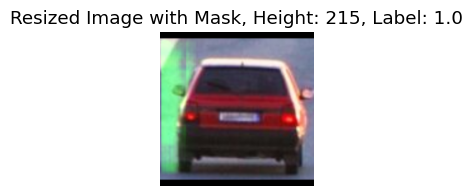

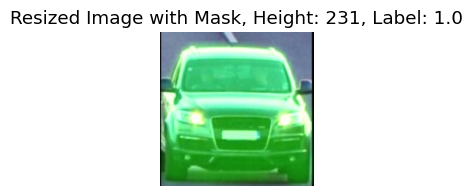

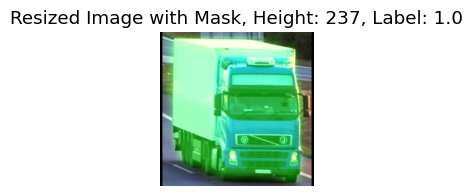

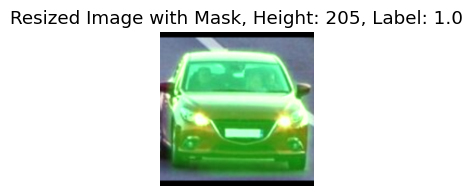

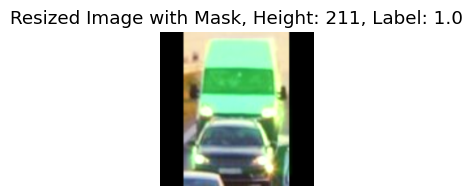

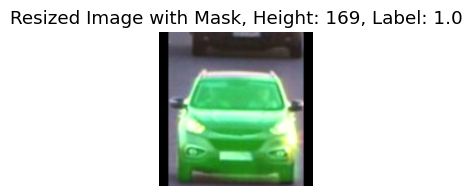

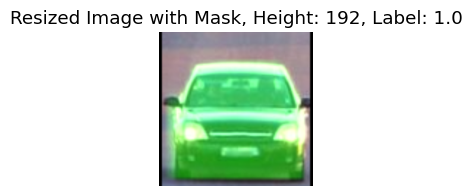

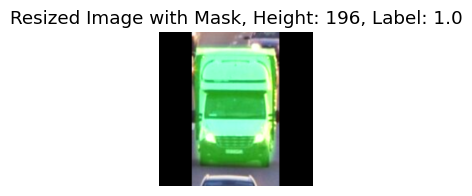

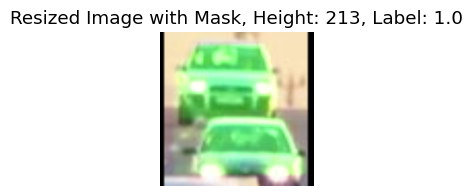

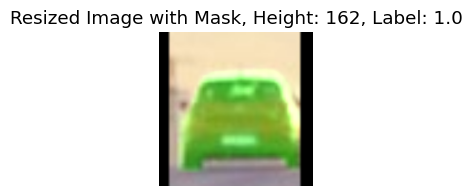

[215, 231, 237, 205, 211, 169, 192, 196, 213, 162]

In [13]:
%matplotlib inline

main("../images/sample3.jpeg")